In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#### Step 1: Exploratory Data Analysis (EDA)
First, we load the dataset. A known issue with this dataset is that missing values are represented by a '?'. We'll load the data and replace these placeholders with NaN (Not a Number) to handle them properly.

In [4]:
df = pd.read_csv('../dataset/adult.csv', na_values='?')

In [5]:
# Display basic information and the first few rows

print("Dataset Information:")
df.info()

print("\nFirst 5 rows:")
print(df.head())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       46033 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   47985 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB

First 5 rows:
   age  workclass  fnlwgt     education 

##### 1.1 Handling Missing Values
Now, let's check how many missing values exist in each column. For simplicity, we will fill missing values in categorical columns with the most frequent value (mode).

In [6]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64


In [7]:
# Fill missing values with the mode
for col in ['workclass', 'occupation', 'native-country']:
    df[col].fillna(df[col].mode()[0], inplace=True)
print("\nMissing values after cleaning:")
print(df.isnull().sum())


Missing values after cleaning:
age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64


C:\Users\Kanif Maruti Kumbhar\AppData\Local\Temp\ipykernel_3660\1094639089.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


##### 1.2 Visualizing Data to Find Outliers
A box-and-whisker plot is perfect for identifying outliers in numerical data. We'll visualize the distributions of the continuous features (age, fnlwgt, capital-gain, capital-loss, hours-per-week).

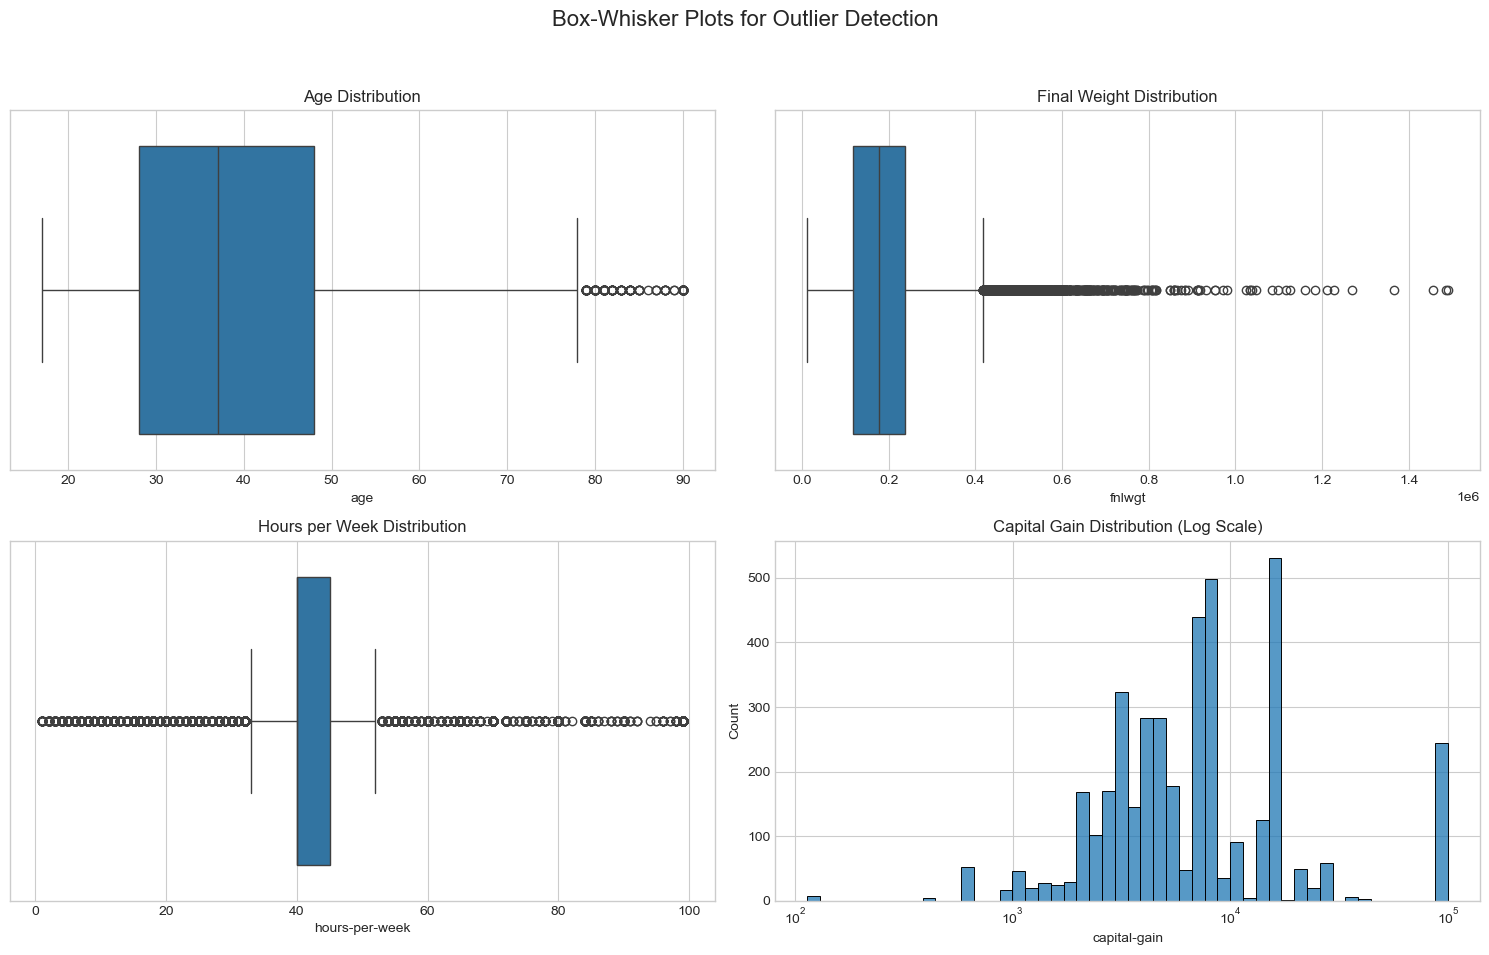

In [8]:
import os

os.makedirs('diagram', exist_ok=True)


plt.style.use('seaborn-v0_8-whitegrid')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Box-Whisker Plots for Outlier Detection', fontsize=16)

# Box plots
sns.boxplot(ax=axes[0, 0], data=df, x='age')
axes[0, 0].set_title('Age Distribution')

sns.boxplot(ax=axes[0, 1], data=df, x='fnlwgt')
axes[0, 1].set_title('Final Weight Distribution')

sns.boxplot(ax=axes[1, 0], data=df, x='hours-per-week')
axes[1, 0].set_title('Hours per Week Distribution')

# Histogram with log scale
sns.histplot(ax=axes[1, 1], data=df, x='capital-gain', bins=50, log_scale=True)
axes[1, 1].set_title('Capital Gain Distribution (Log Scale)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('diagram/box_hist_outliers.png', dpi=300)
plt.show()

Observation from Plots:
* **Age & Hours-per-week:** Have some outliers on the higher end, but they seem plausible (e.g., people working long hours). We will keep them.
* **fnlwgt (final weight):** Has many outliers, but this feature represents census weights, and scaling will handle its wide distribution.
* **Capital Gain/Loss:** These are highly skewed. Many people have zero capital gains or losses. The outliers represent significant financial events, which are likely strong predictors, so we should definitely keep them.

#### Step 2: Data Preprocessing
Now we prepare the data for our PyTorch model. This involves:
1. Separating features (X) from the target (y).
2. Identifying numerical and categorical features.
3. Creating a preprocessing pipeline using scikit-learn to one-hot encode categorical features and scale numerical ones.

In [9]:
# Define target and features
TARGET = 'income'
X = df.drop(TARGET, axis=1)
y = df[TARGET].apply(lambda x: 1 if x == '>50K' else 0) # Convert target to 0s and 1s

In [10]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=np.number).columns

In [11]:
# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [12]:
# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
transformers=[
('num', numerical_transformer, numerical_cols),
('cat', categorical_transformer, categorical_cols)
],
remainder='passthrough' # Keep other columns (if any)
)

##### 2.1 Splitting the Data
We split the data into training (80%) and testing (20%) sets.

In [13]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit the preprocessor on the training data and transform both training and test data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [14]:
# Convert sparse matrix from one-hot encoding to a dense array if necessary
if hasattr(X_train, "toarray"):
    X_train = X_train.toarray()
    X_test = X_test.toarray()

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (39073, 105)
Test data shape: (9769, 105)


#### Step 3: Building the PyTorch Model
Now we'll convert our data into PyTorch tensors and create DataLoaders to feed data to the model in batches.

In [15]:
# Convert data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32)).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32)).unsqueeze(1)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

BATCH_SIZE = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
# Define the model
class IncomeClassifier(nn.Module):
    def __init__(self, input_features):
        super(IncomeClassifier, self).__init__()
        self.layer_1 = nn.Linear(input_features, 128)
        self.layer_2 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))
        return x

In [17]:
# Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]
model = IncomeClassifier(input_features=input_dim)
criterion = nn.BCELoss() # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

IncomeClassifier(
  (layer_1): Linear(in_features=105, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (sigmoid): Sigmoid()
)


#### Step 4: Training the Model
We will train the model for a fixed number of epochs, iterating through the training data in batches. We will also monitor the accuracy on the test set at the end of each epoch to see how well our model is generalizing.

In [18]:
NUM_EPOCHS = 15
train_losses = []
test_accuracies = []

for epoch in range(NUM_EPOCHS):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average training loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Evaluate on the test set
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs.data > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

Epoch [1/15], Loss: 0.3572, Test Accuracy: 85.56%
Epoch [2/15], Loss: 0.3134, Test Accuracy: 85.45%
Epoch [3/15], Loss: 0.3095, Test Accuracy: 85.71%
Epoch [4/15], Loss: 0.3075, Test Accuracy: 85.66%
Epoch [5/15], Loss: 0.3049, Test Accuracy: 85.74%
Epoch [6/15], Loss: 0.3030, Test Accuracy: 85.90%
Epoch [7/15], Loss: 0.3014, Test Accuracy: 85.84%
Epoch [8/15], Loss: 0.3003, Test Accuracy: 85.78%
Epoch [9/15], Loss: 0.2989, Test Accuracy: 85.91%
Epoch [10/15], Loss: 0.2967, Test Accuracy: 85.80%
Epoch [11/15], Loss: 0.2959, Test Accuracy: 85.82%
Epoch [12/15], Loss: 0.2935, Test Accuracy: 85.74%
Epoch [13/15], Loss: 0.2940, Test Accuracy: 85.75%
Epoch [14/15], Loss: 0.2913, Test Accuracy: 85.95%
Epoch [15/15], Loss: 0.2899, Test Accuracy: 85.84%


In [40]:
class ImprovedClassifier(nn.Module):
    def __init__(self, input_features):
        super(ImprovedClassifier, self).__init__()
        self.layer_1 = nn.Linear(input_features, 128)
        self.bn1 = nn.BatchNorm1d(128) # Batch Norm Layer
        self.layer_2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)  # Batch Norm Layer
        self.layer_out = nn.Linear(64, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3) # Slightly increased dropout
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        x = self.layer_1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.sigmoid(self.layer_out(x))
        return x

# --- Re-initialize everything ---
input_dim = X_train.shape[1]
model = ImprovedClassifier(input_features=input_dim) # Use the new model
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Add a learning rate scheduler
# This will decrease the LR by 10% every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

print(model)

ImprovedClassifier(
  (layer_1): Linear(in_features=105, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
)


In [41]:
NUM_EPOCHS = 20 # Train for a bit longer to see effects
train_losses = []
test_accuracies = []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Step the scheduler after each epoch
    scheduler.step()

    # --- Evaluation (same as before) ---
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs.data > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    current_lr = scheduler.get_last_lr()[0] # Get current learning rate
    
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {running_loss/len(train_loader):.4f}, Test Accuracy: {accuracy:.2f}%, LR: {current_lr:.6f}')

Epoch [1/20], Loss: 0.3644, Test Accuracy: 85.35%, LR: 0.001000
Epoch [2/20], Loss: 0.3222, Test Accuracy: 85.53%, LR: 0.001000
Epoch [3/20], Loss: 0.3176, Test Accuracy: 85.70%, LR: 0.001000
Epoch [4/20], Loss: 0.3162, Test Accuracy: 85.54%, LR: 0.001000
Epoch [5/20], Loss: 0.3132, Test Accuracy: 85.71%, LR: 0.000900
Epoch [6/20], Loss: 0.3089, Test Accuracy: 85.94%, LR: 0.000900
Epoch [7/20], Loss: 0.3087, Test Accuracy: 85.91%, LR: 0.000900
Epoch [8/20], Loss: 0.3080, Test Accuracy: 85.87%, LR: 0.000900
Epoch [9/20], Loss: 0.3060, Test Accuracy: 85.71%, LR: 0.000900
Epoch [10/20], Loss: 0.3052, Test Accuracy: 85.94%, LR: 0.000810
Epoch [11/20], Loss: 0.3037, Test Accuracy: 85.82%, LR: 0.000810
Epoch [12/20], Loss: 0.3040, Test Accuracy: 85.91%, LR: 0.000810
Epoch [13/20], Loss: 0.3014, Test Accuracy: 86.01%, LR: 0.000810
Epoch [14/20], Loss: 0.3009, Test Accuracy: 85.94%, LR: 0.000810
Epoch [15/20], Loss: 0.2993, Test Accuracy: 85.87%, LR: 0.000729
Epoch [16/20], Loss: 0.2978, Test 

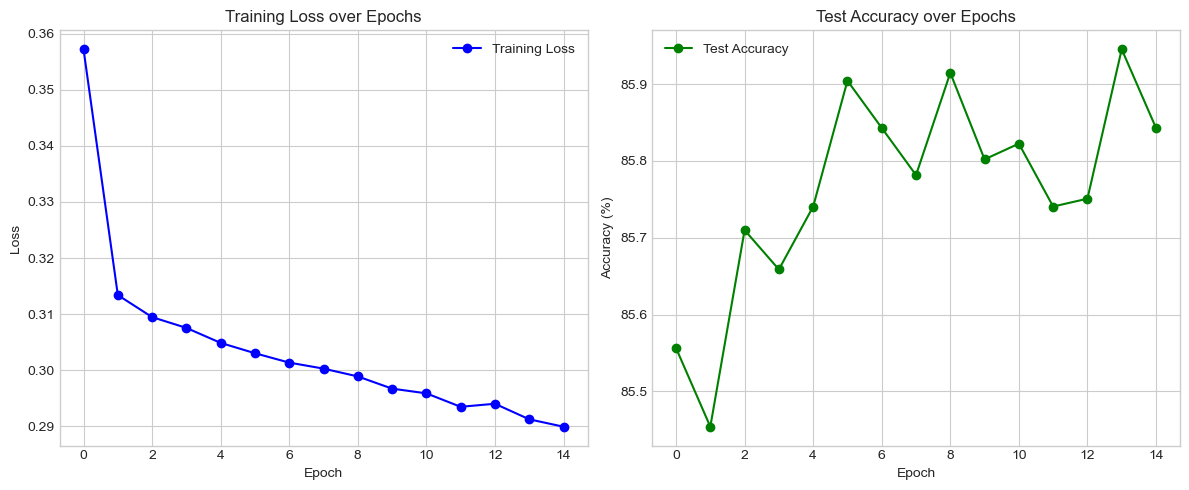

In [21]:
# Plot and save training loss and accuracy
plt.figure(figsize=(12, 5))

# Training loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Test accuracy plot
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='green', marker='o')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("diagram/model_1_loss_accuracy.png")
plt.show()
plt.close()


Accuracy Score: 0.8584

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91      7431
         1.0       0.73      0.65      0.69      2338

    accuracy                           0.86      9769
   macro avg       0.81      0.79      0.80      9769
weighted avg       0.85      0.86      0.86      9769



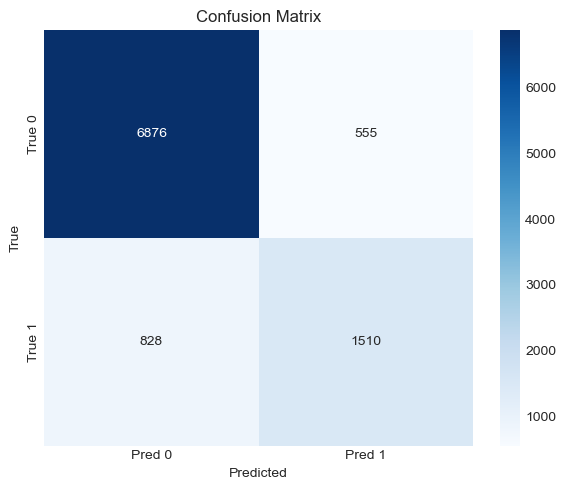

In [22]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs.data > 0.5).float()  # for binary classification
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays and flatten if needed
y_true = np.array(all_labels).flatten()
y_pred = np.array(all_preds).flatten()

# Accuracy
print(f"\nAccuracy Score: {accuracy_score(y_true, y_pred):.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot and save confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("diagram/model_1_confusion_matrix.png")
plt.show()
plt.close()

In [24]:
report = classification_report(y_true, y_pred)

print("\nClassification Report:")
print(report)

# Save to file
with open("diagram/model_1_classification_report.txt", "w") as f:
    f.write("Classification Report for Model 1\n")
    f.write("=====================\n")
    f.write(report)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91      7431
         1.0       0.73      0.65      0.69      2338

    accuracy                           0.86      9769
   macro avg       0.81      0.79      0.80      9769
weighted avg       0.85      0.86      0.86      9769



In [25]:
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/model_1.pth")

In [26]:
# Import necessary libraries
import optuna
from sklearn.metrics import accuracy_score
import xgboost as xgb

# 1. Define the "objective" function for Optuna
# Optuna will try to maximize the return value of this function (in our case, accuracy).
def objective(trial):
    """
    This function takes a 'trial' object, which suggests hyperparameters,
    trains a model with them, and returns the model's accuracy.
    """
    # Define the search space for hyperparameters
    param = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
    'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
    'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
    'max_depth': trial.suggest_int('max_depth', 3, 9),
    'subsample': trial.suggest_float('subsample', 0.6, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    'random_state': 42
}


    # Train the model with the suggested hyperparameters
    model = xgb.XGBClassifier(**param)
    model.fit(X_train, y_train.values)

    # Evaluate the model on the test data
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test.values, preds)

    return accuracy

# 2. Create and run the Optuna study
# We tell Optuna we want to 'maximize' the objective function's result.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Run 50 trials

# 3. Print the best results
print("Best trial finished with value: ", study.best_value)
print("Best hyperparameters found: ", study.best_params)

# 4. Train the final, improved model using the best hyperparameters
best_params = study.best_params
final_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, random_state=42)
final_model.fit(X_train, y_train.values)

# Evaluate the final model
y_pred_final = final_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred_final)

print(f"\nFinal Model Accuracy with Tuned Hyperparameters: {final_accuracy * 100:.2f}%")

[I 2025-07-26 19:45:20,186] A new study created in memory with name: no-name-df5b07c8-b51b-4e70-892b-e66121850244
[I 2025-07-26 19:45:34,322] Trial 0 finished with value: 0.8619101238611936 and parameters: {'lambda': 0.09955325584117146, 'alpha': 0.30724111755634387, 'n_estimators': 897, 'learning_rate': 0.29183366602014194, 'max_depth': 6, 'subsample': 0.9527403395104903, 'colsample_bytree': 0.7837902142437314, 'min_child_weight': 5}. Best is trial 0 with value: 0.8619101238611936.
[I 2025-07-26 19:45:59,842] Trial 1 finished with value: 0.8583273620636708 and parameters: {'lambda': 0.005559499934491737, 'alpha': 0.010584691391790078, 'n_estimators': 994, 'learning_rate': 0.10968537119817101, 'max_depth': 9, 'subsample': 0.7807662539183183, 'colsample_bytree': 0.8034407168027603, 'min_child_weight': 3}. Best is trial 0 with value: 0.8619101238611936.
[I 2025-07-26 19:46:03,676] Trial 2 finished with value: 0.8670283550005118 and parameters: {'lambda': 0.11694108380898065, 'alpha': 9.7

Best trial finished with value:  0.8767529941652165
Best hyperparameters found:  {'lambda': 2.906637813165758e-05, 'alpha': 0.6786773547548443, 'n_estimators': 402, 'learning_rate': 0.16633221769896495, 'max_depth': 3, 'subsample': 0.9395765965859154, 'colsample_bytree': 0.8008601226598181, 'min_child_weight': 7}

Final Model Accuracy with Tuned Hyperparameters: 87.68%


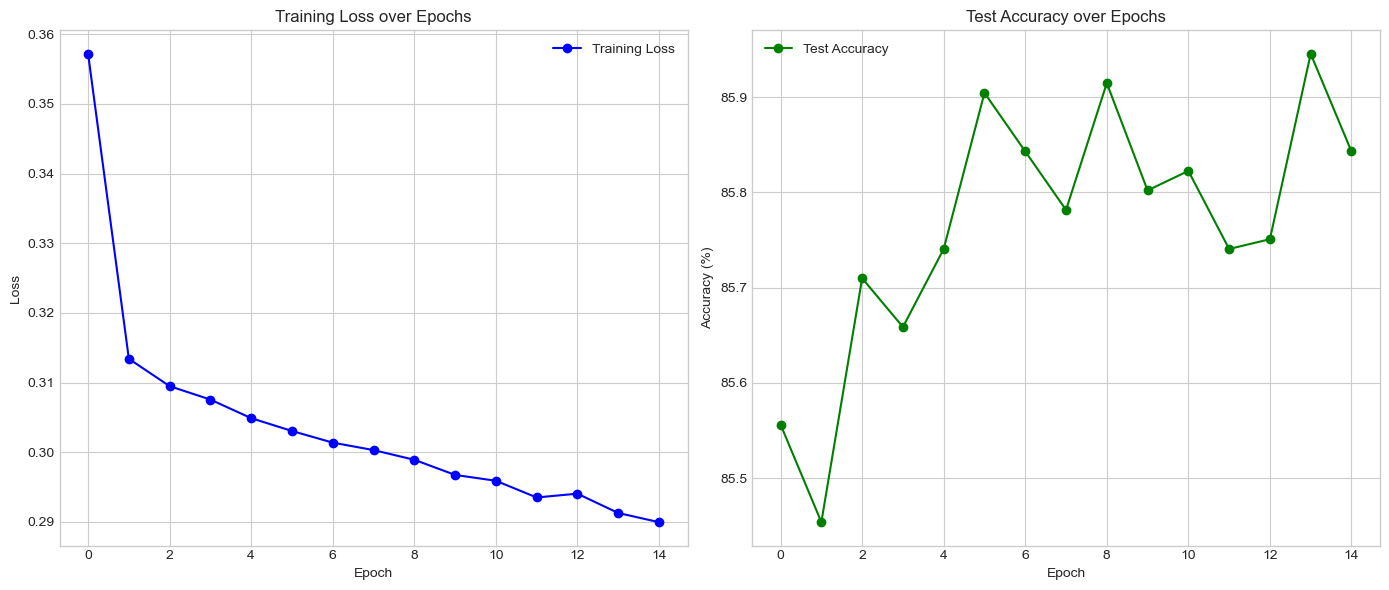

In [29]:
plt.figure(figsize=(14, 6))

# Plot 1: Training Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot 2: Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='green', marker='o')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("diagram/model_1_loss_accuracy.png", dpi=150, bbox_inches='tight')
plt.show()
plt.close()


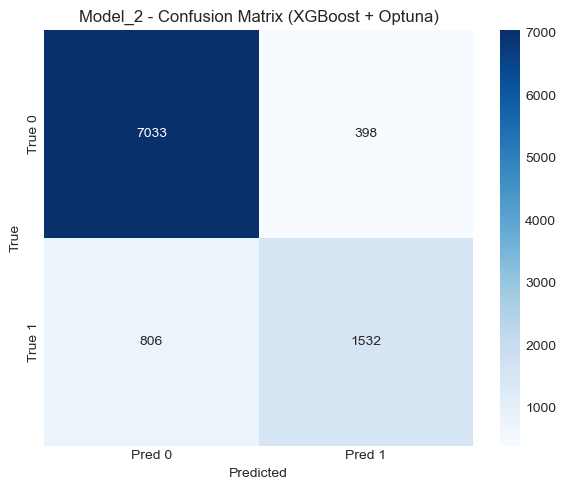

In [31]:
cm = confusion_matrix(y_test, y_pred_final)

# Plot and save
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.title("Model_2 - Confusion Matrix (XGBoost + Optuna)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("diagram/model_2_confusion_matrix.png")
plt.show()
plt.close()

In [32]:
report = classification_report(y_test, y_pred_final)

# Save to file
with open("diagram/model_2_classification_report.txt", "w") as f:
    f.write("Model_2 - Classification Report (XGBoost + Optuna)\n")
    f.write("=" * 60 + "\n")
    f.write(report)

SHAP Summary Plot:


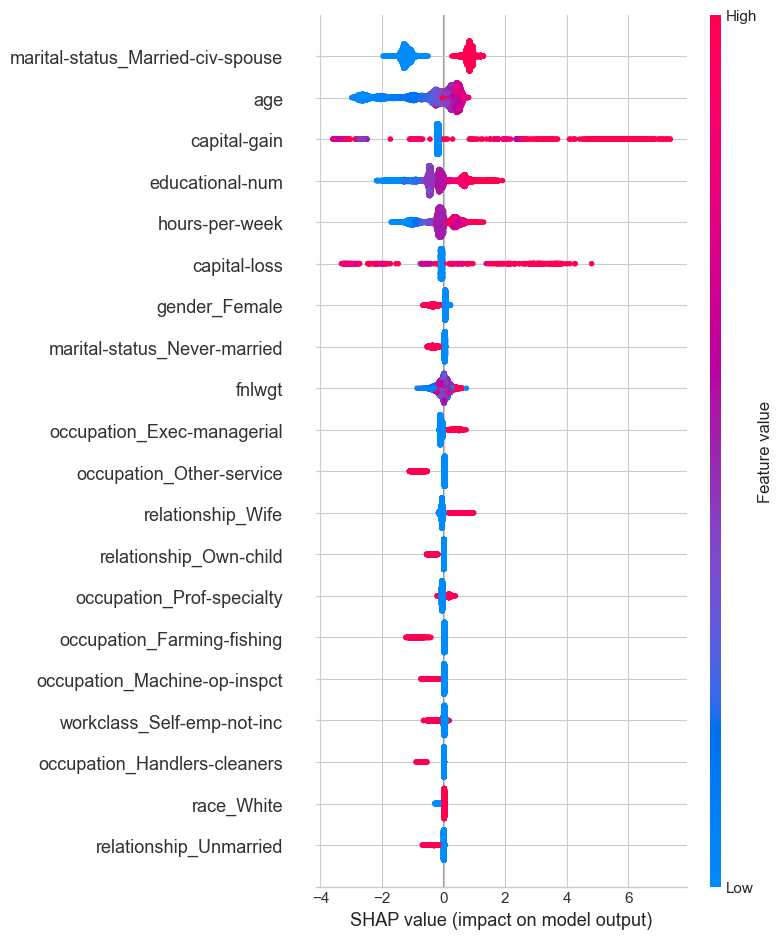

<Figure size 640x480 with 0 Axes>


Explaining a single prediction:


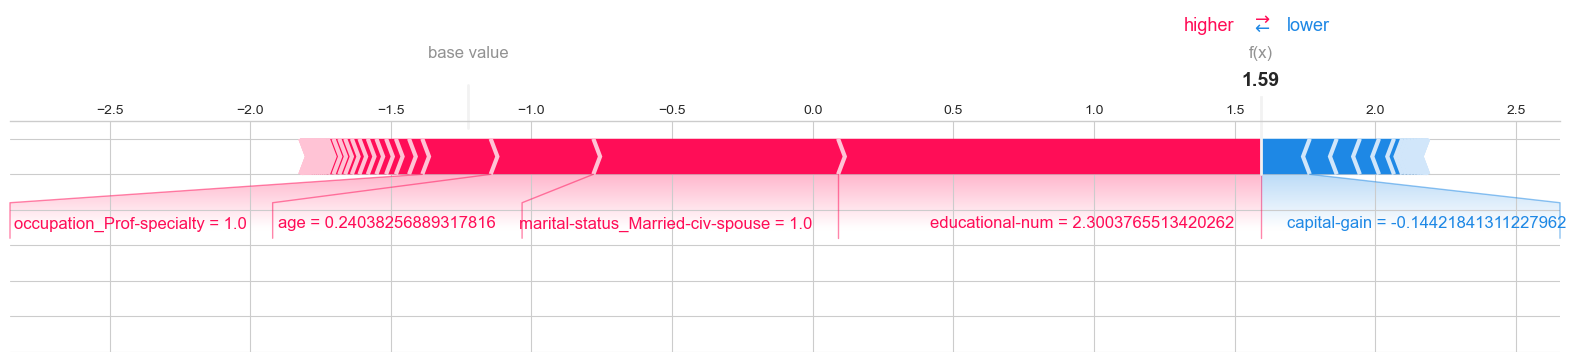

<Figure size 640x480 with 0 Axes>

In [34]:
import shap

# 1. Create a SHAP explainer using your best model
explainer = shap.TreeExplainer(final_model) # Use the 'final_model' we just trained
shap_values = explainer.shap_values(X_test)

# 2. Get the feature names again for plotting
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numerical_cols, ohe_feature_names])

# 3. Create the SHAP summary plot to see global feature importance
print("SHAP Summary Plot:")
shap.summary_plot(shap_values, X_test, feature_names=all_feature_names)

plt.savefig("diagram/model_2_shap_summary.png", bbox_inches="tight", dpi=150)
plt.show()
plt.close()

# 4. Explain a single prediction (e.g., the 10th person in the test set)
print("\nExplaining a single prediction:")
instance_index = 10
shap.force_plot(
    explainer.expected_value,
    shap_values[instance_index,:],
    X_test[instance_index,:],
    feature_names=all_feature_names,
    matplotlib=True
)
plt.savefig("diagram/model_2_shap_force_plot.png", bbox_inches="tight", dpi=150)
plt.show()

In [37]:
import joblib

joblib.dump(final_model, "models/model_2_optuna_xgb.pkl")
print("Model saved to models/model_2_optuna_xgb.pkl")

# Save SHAP values and test set for later analysis
np.save("models/model_2_shap_values.npy", shap_values)
np.save("models/model_2_X_test_values.npy", X_test)

Model saved to models/model_2_optuna_xgb.pkl


In [39]:
# Save the final model
joblib.dump(final_model, 'models/xgb_model.joblib')

# Save the preprocessor
joblib.dump(preprocessor, 'models/preprocessor.joblib')

print("Model and preprocessor saved!")

Model and preprocessor saved!
